
Enter image path (or 'q' to quit):  farm.jpg



Image Segmentation Menu:
1. Basic Thresholding (Otsu's method)
2. Adaptive Thresholding
3. Region Growing
4. Watershed Segmentation
5. K-means Segmentation
6. Load Different Image
7. Exit



Enter your choice (1-7):  1


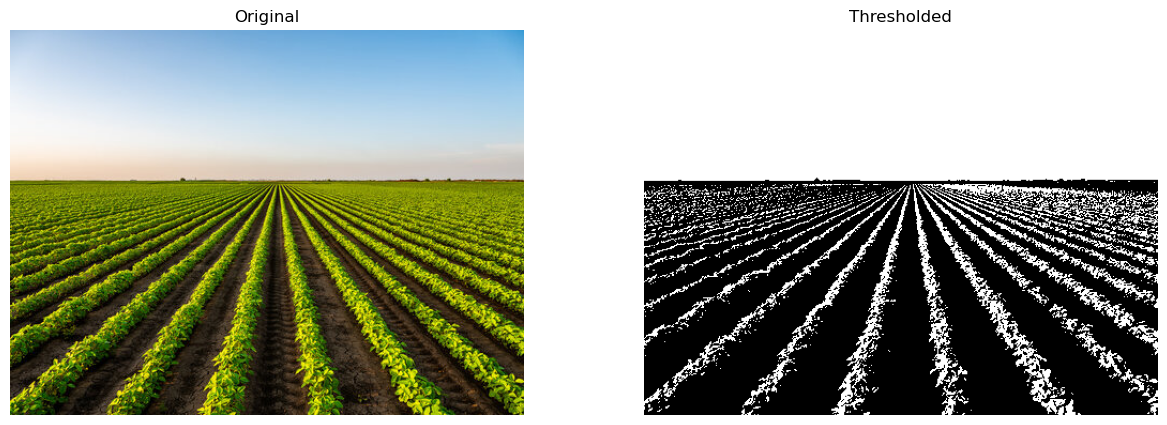


Image Segmentation Menu:
1. Basic Thresholding (Otsu's method)
2. Adaptive Thresholding
3. Region Growing
4. Watershed Segmentation
5. K-means Segmentation
6. Load Different Image
7. Exit



Enter your choice (1-7):  2


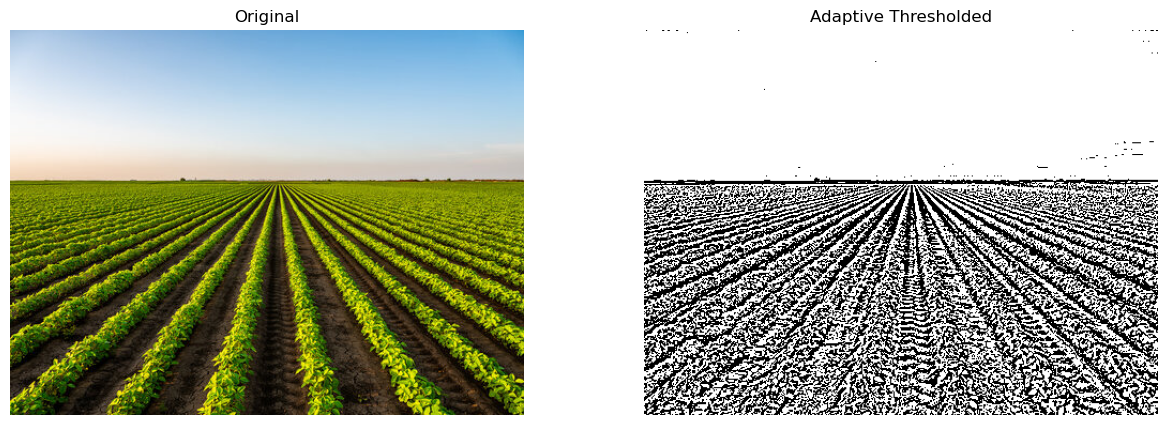


Image Segmentation Menu:
1. Basic Thresholding (Otsu's method)
2. Adaptive Thresholding
3. Region Growing
4. Watershed Segmentation
5. K-means Segmentation
6. Load Different Image
7. Exit



Enter your choice (1-7):  3


Click on the image to select seed point, or press any key to use center point


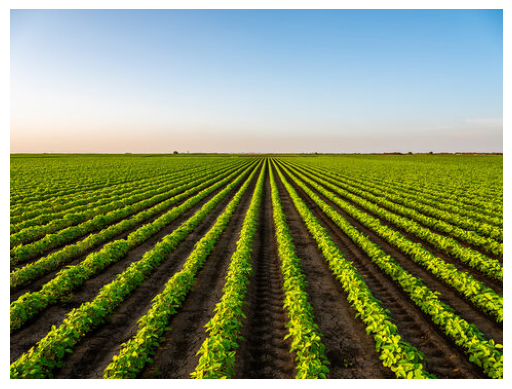

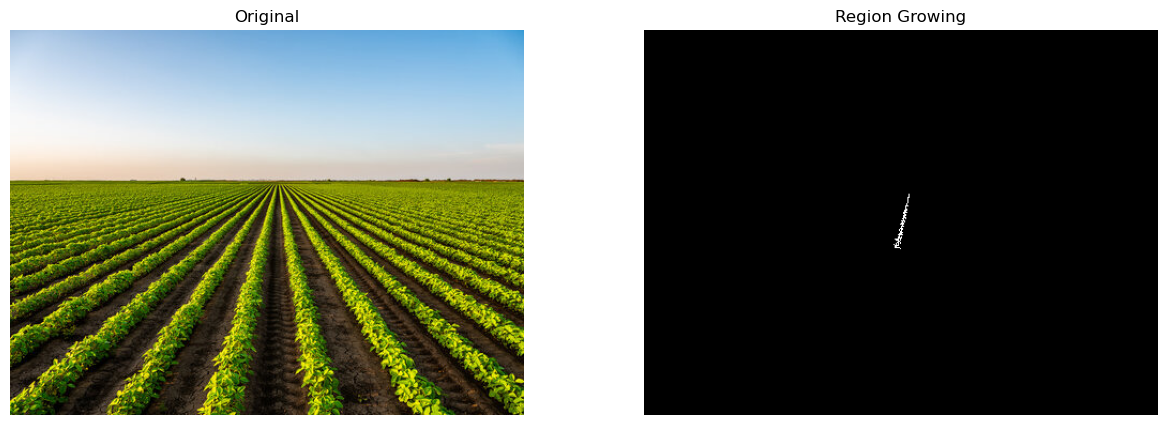


Image Segmentation Menu:
1. Basic Thresholding (Otsu's method)
2. Adaptive Thresholding
3. Region Growing
4. Watershed Segmentation
5. K-means Segmentation
6. Load Different Image
7. Exit



Enter your choice (1-7):  4


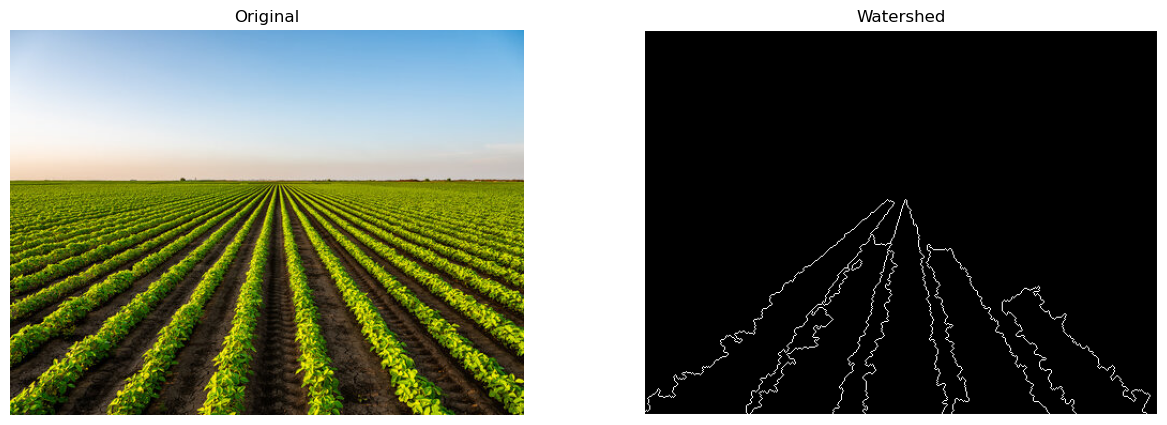


Image Segmentation Menu:
1. Basic Thresholding (Otsu's method)
2. Adaptive Thresholding
3. Region Growing
4. Watershed Segmentation
5. K-means Segmentation
6. Load Different Image
7. Exit



Enter your choice (1-7):  7


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def display_results(images, titles):
    """Display multiple images with their titles"""
    n = len(images)
    plt.figure(figsize=(15, 5))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def threshold_segmentation(image):
    """Apply Otsu's thresholding"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
        
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def region_growing(image, seed_point=None):
    """
    Region growing segmentation
    If seed_point is None, uses the center of the image as seed point
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
        
    if seed_point is None:
        seed_point = (gray.shape[0]//2, gray.shape[1]//2)
    
    # Create a mask for the segmented region
    mask = np.zeros(gray.shape, dtype=np.uint8)
    
    # Set seed point
    mask[seed_point[0], seed_point[1]] = 255
    
    # Get seed point intensity
    seed_intensity = int(gray[seed_point[0], seed_point[1]])
    
    # Threshold for intensity difference
    threshold = 30
    
    # Region growing
    while True:
        mask_old = mask.copy()
        
        # Dilate the current region
        kernel = np.ones((3,3), np.uint8)
        mask_dilated = cv2.dilate(mask, kernel, iterations=1)
        
        # Get pixels that are in dilated mask but not in current mask
        new_pixels = cv2.subtract(mask_dilated, mask)
        
        # Get intensities of these pixels in original image
        coords = np.where(new_pixels > 0)
        for x, y in zip(coords[0], coords[1]):
            if abs(int(gray[x,y]) - seed_intensity) < threshold:
                mask[x,y] = 255
        
        # If no new pixels were added, stop
        if np.array_equal(mask, mask_old):
            break
    
    return mask

def watershed_segmentation(image):
    """Apply watershed segmentation"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Finding unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), markers)
    
    # Create the result image
    result = np.zeros_like(gray)
    result[markers == -1] = 255  # Boundaries
    
    return result

def adaptive_thresholding(image):
    """Apply adaptive thresholding"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
        
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY, 11, 2)

def kmeans_segmentation(image, k=3):
    """Apply K-means segmentation"""
    # Reshape image for k-means
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    
    # Define criteria and apply kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, 
                                  cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to uint8 and reshape
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

def main():
    while True:
        # Get image path from user
        image_path = input("\nEnter image path (or 'q' to quit): ")
        
        if image_path.lower() == 'q':
            break
            
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
                
            while True:
                print("\nImage Segmentation Menu:")
                print("1. Basic Thresholding (Otsu's method)")
                print("2. Adaptive Thresholding")
                print("3. Region Growing")
                print("4. Watershed Segmentation")
                print("5. K-means Segmentation")
                print("6. Load Different Image")
                print("7. Exit")
                
                choice = input("\nEnter your choice (1-7): ")
                
                if choice == '1':
                    result = threshold_segmentation(image)
                    display_results([image, result], ['Original', 'Thresholded'])
                    
                elif choice == '2':
                    result = adaptive_thresholding(image)
                    display_results([image, result], ['Original', 'Adaptive Thresholded'])
                    
                elif choice == '3':
                    print("Click on the image to select seed point, or press any key to use center point")
                    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    seed_point = None
                    def onclick(event):
                        nonlocal seed_point
                        if event.xdata is not None and event.ydata is not None:
                            seed_point = (int(event.ydata), int(event.xdata))
                            plt.close()
                    fig = plt.gcf()
                    fig.canvas.mpl_connect('button_press_event', onclick)
                    plt.show()
                    
                    result = region_growing(image, seed_point)
                    display_results([image, result], ['Original', 'Region Growing'])
                    
                elif choice == '4':
                    result = watershed_segmentation(image)
                    display_results([image, result], ['Original', 'Watershed'])
                    
                elif choice == '5':
                    k = int(input("Enter number of segments (2-10): "))
                    k = max(2, min(10, k))  # Ensure k is between 2 and 10
                    result = kmeans_segmentation(image, k)
                    display_results([image, result], ['Original', f'K-means (k={k})'])
                    
                elif choice == '6':
                    break
                    
                elif choice == '7':
                    return
                    
                else:
                    print("Invalid choice! Please enter a number between 1 and 7.")
                    
        except Exception as e:
            print(f"Error: {str(e)}")
            print("Please try again with a valid image path.")

if __name__ == "__main__":
    main()